## Imports

In [1]:
# this is a hack to have pylance working with tensorflow and keras
import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
keras = tf.keras

# Data Preparation

## Function to read all images

In [2]:
def read_images(glob_pattern: str) -> list[str]:
    files = glob.glob(glob_pattern)
    images: list[Image.Image] = []
    for file in files:
        image = Image.open(file)
        image = np.array(image)[:, :, 0]  # select 1st channel
        images.append(image)
    return images

## Read the images with the function above

In [3]:
ships_list = read_images('../data/ship_detection/00_Ships/*.png')
no_ships_list = read_images('../data/ship_detection/00_NoShips/*.png')

## Check how many images were loaded

In [4]:
len(no_ships_list)

1800

## Plot a random image to check if everything worked so far

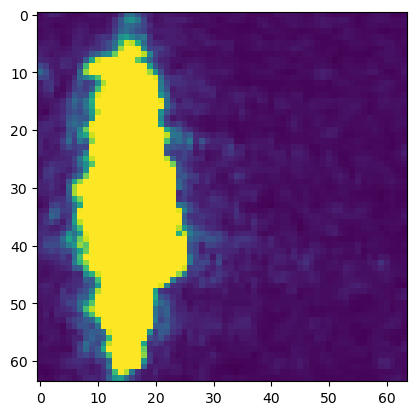

In [5]:
plt.imshow(ships_list[150])

## Turn data into concatenated arrays to create x data (all images in one variable)

In [6]:
ships = np.asarray(ships_list)
no_ships = np.asarray(no_ships_list)
no_ships.shape

(1800, 64, 64)

In [7]:
x = np.concatenate([ships, no_ships])
x.shape

(3149, 64, 64)

## Create y data (0 for no ships and 1 for ships)

In [8]:
y_ships = np.ones(len(ships))
y_no_ships = np.zeros(len(no_ships))

y = np.concatenate([y_ships, y_no_ships])
y.shape

(3149,)

## Train test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

## Scale the data

In CNNs scaling the Input data to a range between 0 and 1 is not as important as in ANNs.
</br>
However, it usually does not do any harm to our network, so it is usually done.
</br>We can easily scale the input data between 0 and 1 by dividing it through the max pixel value. 8bit = 256 values (max=255)

In [10]:
x_train_scaled = x_train/np.max(x_train)
x_test_scaled = x_test/np.max(x_train)

In [11]:
y_train_scaled = y_train/np.max(y_train)
y_test_scaled = y_test/np.max(y_test)

***
# Built a model

In [ ]:
# Conv2D?

In [12]:
model = keras.models.Sequential()

model.add(
    keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3),
        padding='same', activation='relu', input_shape=(64, 64, 1),
    ),
)
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(rate=0.2))

model.add(
    keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), activation='relu',
    ),
)
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train_scaled, y_train_scaled, epochs=20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 64)        0

## Plot the learning history

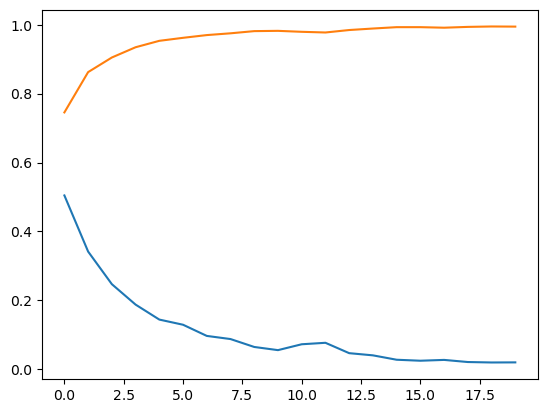

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

## Evaluate the model

In [14]:
# Get trainings data accuracy
model.evaluate(x_train_scaled, y_train_scaled)

79/79 [==============================] - 1s 8ms/step - loss: 0.0246 - accuracy: 0.9980


[0.024616455659270287, 0.9980151057243347]

In [15]:
# Get testing data accuracy
model.evaluate(x_test_scaled, y_test_scaled)

20/20 [==============================] - 0s 14ms/step - loss: 0.2599 - accuracy: 0.9635


[0.25990360975265503, 0.9634920358657837]

## Check some random predicted samples

Real class: 1.0
Input feature:


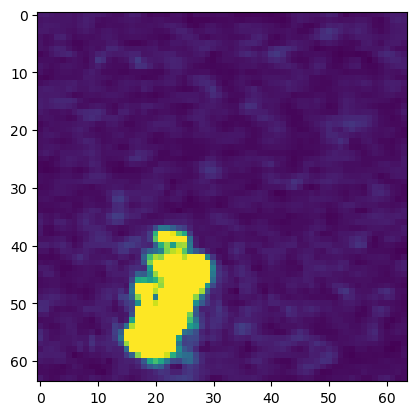

In [17]:
feature = 51  # 29, 51
print(f'Real class: {y_test_scaled[feature]}')
print('Input feature:')
plt.imshow(x_test_scaled[feature, :, :])

In [18]:
model.predict(x_test_scaled[feature, :, :].reshape(1, 64, 64, 1))

1/1 [==============================] - 0s 179ms/step


array([[0.9999995]], dtype=float32)

## Save the model

In [19]:
model.save('ship_detection_model.h5')